---
<div align="center">
    
# S&P-500 | Stock Forecasting and Optimization
</div>

---

---
<div align="center">
    
## Problem Formulation [TO BE FIXED LATER]
</div>

---

### Context

The stock market is highly volatile and unpredictable which makes stock price forecasting and portfolio optimization challenging tasks. Therefore, since investors seek strategies that can provide risk-adjusted returns efficiently, this project aims to help them.

### Resolution Approach

This project focuses on using machine learning algorithms to forecast future stock prices of the S&P-500 Market Index and thereafter apply optimization methods to select the best set of stocks for daily investment. 

It combines data-driven forecasts with optimization techniques to maximize returns or minimize risks, creating a solution for real-world financial challenges.

### Planned Work

To properly develop this project, we have structured it along the following phases:
1. Data Preprocessing & Engineering
2. Data Cleaning
3. Exploratory Data Analysis - We aim to obtain greater insights on how the data 
4. Model Development and Evaluation - Use models like LSTMs, LGBM, Using proper training methodologies [Use a Window and simply move it N days further at each iteration and consider the new window as the training data of the model until we have reached the end of the data, aka, 2024 ]. Note: Always test with the 2024 data.
6. Portfolio Optimization - Using Monte Carlo, Min-Max and even genetic Algorithms
7. Results Analysis

---
<div align="center">
    
## Project Dependencies

</div>

---

In [1]:
# !pip install requests-cache requests-ratelimiter
# !pip install --upgrade yfinance
# !pip install PyPortfolioOpt

In [2]:
# !pip install scikit-learn==0.21.3
# !pip install Cython
# !pip install fbprophet
# !conda install -c anaconda ephem -y
# !conda install -c conda-forge pystan -y
# !conda install -c conda-forge fbprophet -y
# !pip install holidays==0.9.12

# !pip install pystan==2.19.1.1 prophet
# !pip install cmdstanpy==0.9.5

# !pip install fbprophet==0.6
# !pip install holidays==0.9.11

# !pip install lightgbm 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Importing Dependencies
import numpy as np
import pandas as pd

# Import json to help save dictionaries into .json files
import json

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)
from datetime import datetime as dt

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf
from yfinance import (Ticker)

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

from DataPreProcessing.DataExtraction import (extractSP500StocksInformationWikipedia, getSP500StockMarketInformation, getStockMarketInformation, mergeStocksClosingPrices, selectStocksToUse)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotStockClosingPrice, plotStockStats)

from ModelDevelopmentAndEvaluation.StockPriceManager import (stockPriceManager)
from ModelDevelopmentAndEvaluation.StockPricePredictor import (StockPricePredictor)
from ModelDevelopmentAndEvaluation.DataManagement import (getStocksPredictions)
from ModelDevelopmentAndEvaluation.DataVisualization import (plotStocksRawResults)

from Utils.Configuration import (loadConfig, loadInitialPathsConfig, loadFinalPathsConfig, loadInitialSetup)

# from pprint import pprint

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [7]:
from tensorflow.python.client import device_lib

# List all available devices
print("Available devices:")
print(device_lib.list_local_devices())


Available devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7752838893380070223
xla_global_id: -1
]


In [8]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow can access GPUs
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
else:
    print("GPU is not available.")


TensorFlow version: 2.10.0
GPU is not available.


In [9]:
# Load the configs
config = loadConfig()
pathsConfig = loadInitialPathsConfig()
initialSetup = loadInitialSetup()
initialSetup

{'initialMoney': 1000,
 'buyFee': 1,
 'sellFee': 1,
 'limitStocksPerDay': 100,
 'minimizeRisk': True,
 'maximizeRisk': False,
 'minimizeReturn': False,
 'maximizeReturn': True}

---
<div align="center">

## Data Preprocessing
</div>

---

As a first approach, we started to analyse the available data in order to gain deeper insights on how it is distributed so that we can process it and consequently later feed it to machine learning models so that they can help us predict the closing prices of multiple stocks for January 2024.

---
### Exploratory Data Analysis
---

We started by analysing a simple dataset containing multiple stocks and some important information related to them, such as their Last Sale, Net Change and Market Cap. 
> This dataset is Available [here](https://www.nasdaq.com/market-activity/stocks/screener)

In [10]:
# It consists of all the publicly available stocks globally
worldWideStocks = pd.read_csv('./Datasets/Stocks.csv')
worldWideStocks.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$139.65,2.780,2.031%,4.012531e+10,United States,1999.0,1795434,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$40.73,0.160,0.394%,1.052279e+10,United States,2016.0,2930997,Industrials,Aluminum
2,AACG,ATA Creativity Global American Depositary Shares,$1.04,0.030,2.97%,3.328014e+07,China,2008.0,64843,Real Estate,Other Consumer Services
3,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.87,-0.005,-0.046%,0.000000e+00,NaN,2023.0,26869,Finance,Blank Checks
4,AADI,Aadi Bioscience Inc. Common Stock,$1.96,-0.030,-1.508%,4.824508e+07,United States,NaN,24640,Health Care,Biotechnology: Pharmaceutical Preparations


In [11]:
# Extract some information of the S&P-500 Stocks from wikipedia
sp500Stocks = extractSP500StocksInformationWikipedia(pathsConfig)

# Compute the unique stocks
uniqueStocks = np.unique(sp500Stocks.Symbol.to_numpy())
print(f"There are {uniqueStocks.size} Unique Stocks out of {sp500Stocks.shape[0]} total Available Stocks on the S&P 500 Program.")

There are 503 Unique Stocks out of 503 total Available Stocks on the S&P 500 Program.


Which means that each row corresponds to a different stock.

However, since the project mainframe relies over the S&P-500 Market Index Fund, we have to restrict our analysis to them for the purpose of our task. Additionaly, and to further improve our understanding the stock's composition of this Market Index Fund, we extracted a table from Wikipedia with important information related to it, as this ranges from the Industry Sector they are mainly focused on (__*GICS Sector*__) to the Year their were founded on (__*Founded*__).

In [12]:
# Inspect the DataFrame
sp500Stocks.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008
4,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888


On a additional note, let's check the distribution of the S&P-500 Stocks throughout the available Industry Sectors, as to better infer which industry sectors provide the best candidates for our Portfolio Optimization task.

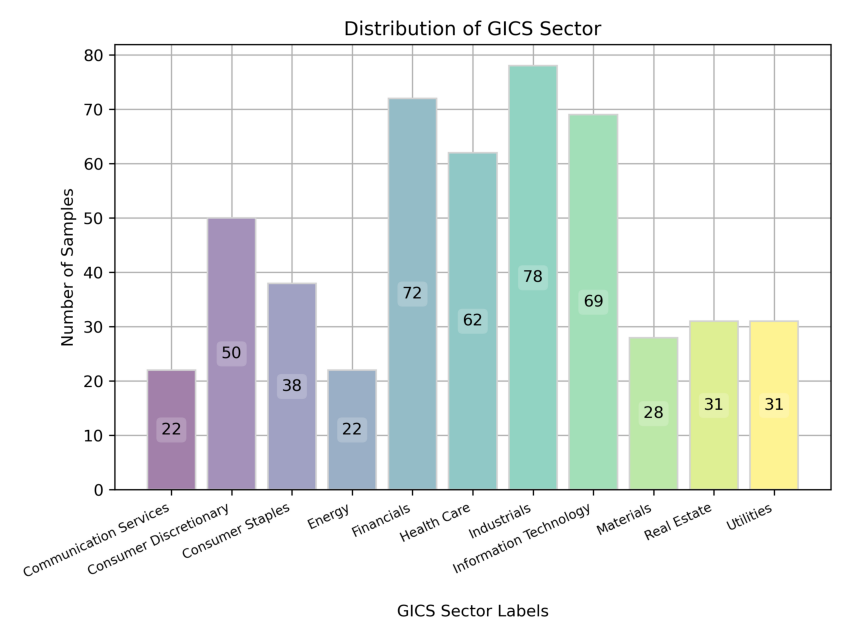

In [13]:
# Plot the Distribution for the GICS Sectors of all the Companies
plotFeatureDistribution(df=sp500Stocks, classFeature='GICS Sector', forceCategorical=False, pathsConfig=pathsConfig, featureDecoder=None)

However, despite the analysis of the sector distribution, our main focus is to rely on the closing prices of the stocks that incorporate the index fund. Therefore, and for simplicity reasons, let's start by analysing how this Market Index Fund has performed over the last few years.

In [14]:
# Extract a S&P-500 Stock Market Information
sp500MarketHistory = getSP500StockMarketInformation(config=config, pathsConfig=pathsConfig)

# Inpect the DataFrame
sp500MarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,0.016043
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,0.003116
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,0.000546
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,0.004001
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,0.002882


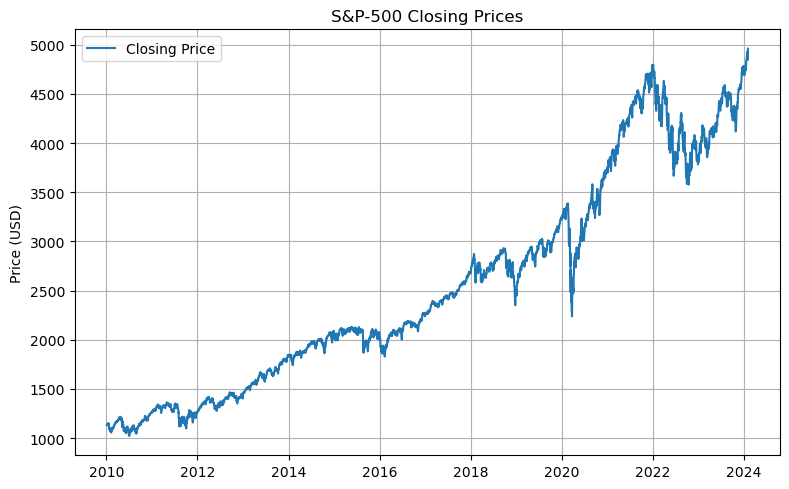

In [15]:
# Let's see a historical view of the closing price
plotStockClosingPrice(stockMarketHistory=sp500MarketHistory, title='S&P-500 Closing Prices')

Regarding to our project setting, we are to filter the dates in which we want to perform inference upon, i.e., the dates to consider when performing the later portfolio optimization.

In [16]:
# Extract the dates in which the market is open in January 2024 - Days in which we are going to perform inference
predictionDates = sp500MarketHistory[sp500MarketHistory['Date'] >= str(dt(2024, 1, 1).date())][sp500MarketHistory['Date'] < str(dt(2024, 2, 1).date())]['Date'].to_numpy()
predictionDates

array(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
       '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
       '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18',
       '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24',
       '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30',
       '2024-01-31'], dtype=object)

In [17]:
# Let's update the paths dictionary to include the paths in which to save the Extracted Data and Trained Models
pathsConfig = loadFinalPathsConfig(stocks=uniqueStocks, predictionDates=predictionDates)

---
### Feature Extraction and Creation
---

To properly provide a solution to our task and since we are simply preocupied in predicting the closing prices for each stock of the market index for each open day of January of 2024, we started by incorporating the use of the YFinance Package API to help us extract this valuable information.

Therefore, we are to extract each stock's available data on the maximal interval between 2010 and 2024, even if they started existing after 2010.

> MENTION THAT THE DATA OF 2024 IS ONLY USED TO EVALUATE THE ERROR MADE BY THE PREDICTORS.

> ADD CONTENT TO HOW THE FEATURE EXTRACTION WAS PERFORMED WITH HELP OF THE YFINANCE APi

> MENTION ALL THE NEW METRICS CREATED TO BETTER DETERMINE THE VOLATILITY OF A STOCK

In [18]:
# EXAMPLE ON HOW TO EXTRACT A STOCK'S MARKET INFORMATION INTO A DATAFRAME

# Extract a Stock's Market Information
stockMarketHistory = getStockMarketInformation(stockSymbol='NVDA', config=config, pathsConfig=pathsConfig)
stockMarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,EMA,UpperBB,LowerBB,Daily_Return,Cumulative_Return,Window_Return,Volatility
0,2010-01-04,0.424410,0.426933,0.415239,0.423952,800204000,0.0,0.0,0.386383,0.388421,0.448433,0.324333,-0.010171,1.324499,0.336949,0.105565
1,2010-01-05,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0,0.391542,0.392395,0.449835,0.333250,0.014602,1.343840,0.315568,0.102702
2,2010-01-06,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0,0.394741,0.396252,0.454801,0.334681,0.006397,1.352436,0.173400,0.104711
3,2010-01-07,0.430601,0.432435,0.421200,0.424410,547792000,0.0,0.0,0.398409,0.398934,0.456148,0.340670,-0.019598,1.325931,0.209013,0.100835
4,2010-01-08,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0,0.401688,0.401447,0.457603,0.345773,0.002161,1.328797,0.182282,0.101442


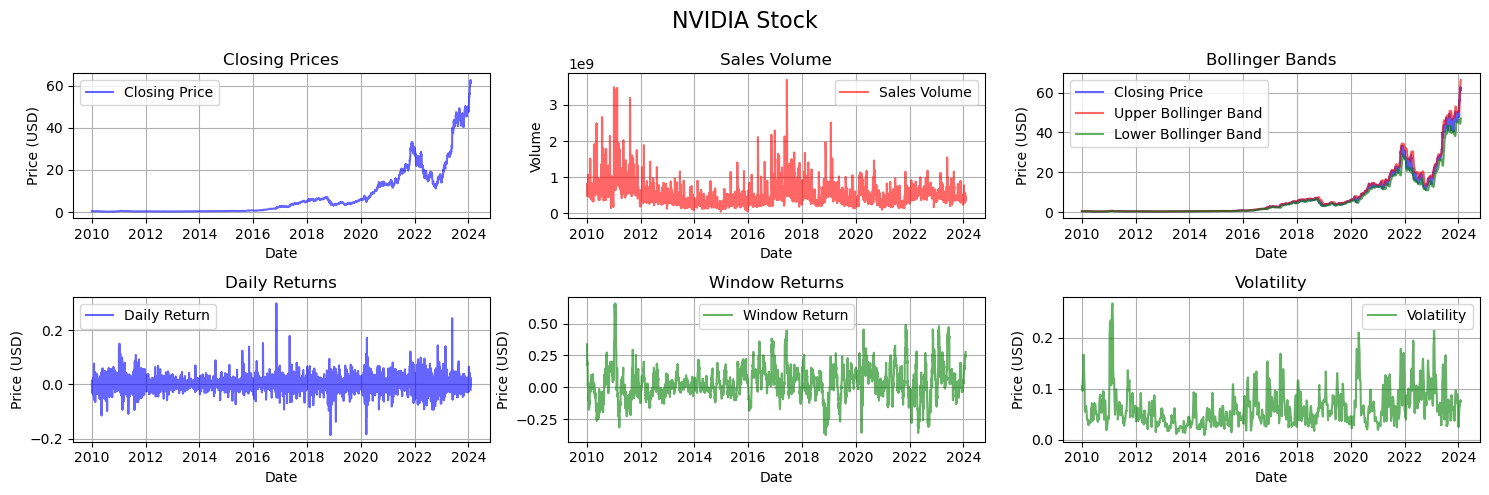

In [19]:
# Plotting the NVIDIA Statistics over the years
plotStockStats(stockMarketHistory=stockMarketHistory, title='NVIDIA Stock')

> EXEMPLIFY THE PIPELINE WITH A STOCK TO SHOWCASE WHAT IS HAPPENING

In [20]:
# Create a instance of a stock price manager
ds = stockPriceManager(stockSymbol='NVDA', feature='Close', windowSize=config['window'], predictionDate='2024-01-02', pathsConfig=pathsConfig)

# Split the data accordingly
x_train, y_train, x_test, y_test = ds.trainTestSplit()

# Print the train and test set's shapes
print(f"X_train: {x_train.shape} \t y_train: {y_train.shape}")
print(f"X_test: {x_test.shape} \t y_test: {y_test.shape}")

X_train: (3502, 19) 	 y_train: (3502,)
X_test: (1, 19) 	 y_test: (1,)


In [21]:
# Create a instace of a Stock Price Predictor
nvdaPredictor = StockPricePredictor(stockSymbol="NVDA", datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

In [22]:
# Train the selected models to perform inference
nvdaRawForecast, nvdaForecast = nvdaPredictor.trainModels()

In [23]:
# Check the raw predictions for the NVDA Stock over the first 5 days of January 2024
nvdaRawForecast.head()

,Date,[Random Forest] Prediction,[Random Forest] Mean Absolute Error,[Random Forest] Mean Absolute Percentage Error (%),[LGBM] Prediction,[LGBM] Mean Absolute Error,[LGBM] Mean Absolute Percentage Error (%),[XGBoost] Prediction,[XGBoost] Mean Absolute Error,[XGBoost] Mean Absolute Percentage Error (%),[LSTM] Prediction,[LSTM] Mean Absolute Error,[LSTM] Mean Absolute Percentage Error (%),Target
0,2024-01-02,39.176,0.784,1.961,41.949,1.989,4.978,39.352,0.608,1.522,39.027,0.934,2.336,39.960
1,2024-01-03,39.313,0.444,1.143,41.912,3.043,7.829,39.016,0.147,0.379,39.063,0.195,0.501,38.869
2,2024-01-04,38.723,0.337,0.878,40.491,2.105,5.483,38.345,0.041,0.107,39.072,0.687,1.789,38.386
3,2024-01-05,38.550,0.182,0.470,40.845,2.113,5.457,37.614,1.117,2.885,38.625,0.107,0.276,38.732
4,2024-01-08,38.595,1.023,2.581,42.087,2.469,6.233,37.955,1.662,4.196,39.271,0.347,0.875,39.618


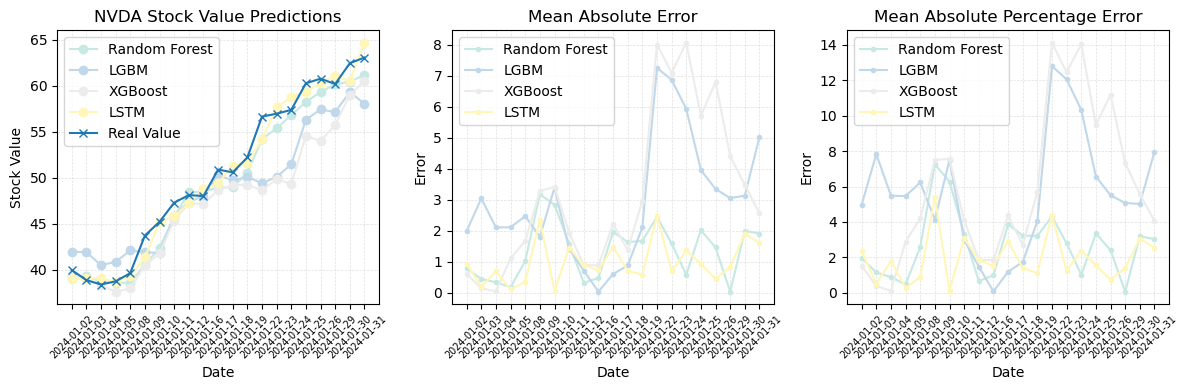

In [105]:
# Plot the Prediction results for the NVDA Stock
plotStocksRawResults(stockSymbol='NVDA', pathsConfig=pathsConfig)

In [24]:
# Check the price forecasting for the NVDA Stock for the first 5 days of January 2024
nvdaForecast.head()

,Date,NVDA
0,2024-01-02,39.876
1,2024-01-03,39.826
2,2024-01-04,39.158
3,2024-01-05,38.908
4,2024-01-08,39.477


> SELECT ONLY A FEW OF THE STOCKS DUE TO THE OVERWHELMING AMOUNT TO TRAIN MODELS ON AND ALSO PERFORM PORTFOLIO OPTIMIZATION WITH
> WE HAVE SELECTED 5 PER GICS SECTOR TO SIMPLIFY THE PROBLEM

In [25]:
# Select the most important stocks per Industry Sector
selectedStocks = selectStocksToUse(worldWideStocks=worldWideStocks, sp500Stocks=sp500Stocks, numberStocks=5)
selectedStocks.head()

,Symbol,Name,Sector
0,GOOGL,Alphabet Inc. Class A Common Stock,Communication Services
1,GOOG,Alphabet Inc. Class C Capital Stock,Communication Services
2,META,Meta Platforms Inc. Class A Common Stock,Communication Services
3,FOXA,Fox Corporation Class A Common Stock,Communication Services
4,FOX,Fox Corporation Class B Common Stock,Communication Services


In [26]:
# Create a vector to store all the extracted stocks
extractedStocks = []

# Extract the market informations for all stocks
for symbol in selectedStocks.Symbol:
    X = getStockMarketInformation(stockSymbol=symbol, config=config, pathsConfig=pathsConfig)
    if X is None:
        pass
    else:
        # Update the extracted stocks list
        extractedStocks.append(symbol)

In [27]:
# Iterate through the extracted data
for symbol in extractedStocks:
    # Compute a windowed DataFrame to be later used to feed our models
    _ = stockPriceManager(stockSymbol=symbol, feature='Close', windowSize=config['window'], predictionDate='2024-01-01', pathsConfig=pathsConfig)
    # print(f"[{symbol}] Processed Successfully!")

In [28]:
# Iterate through the selected stocks
for stockSymbol in extractedStocks:
    # print("\n[CURRENT STOCK]", stockSymbol)
    # Create a instance of a StockPricePredictor for the current Stock
    stockPredictor = StockPricePredictor(stockSymbol=stockSymbol, datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

    # Compute the models to predict the closing prices of each day in January 2024
    stockPredictor.trainModels()

In [32]:
# Merge all the stock predictions into a single DataFrame
stockPredictions = getStocksPredictions(stocks=extractedStocks, pathsConfig=pathsConfig)
stockPredictions.head()

,Date,GOOGL,GOOG,META,FOXA,FOX,AMZN,EBAY,F,TPR,...,PSA,SPG,MAA,UDR,CSGP,AES,NEE,PPL,CNP,NRG
0,2024-01-02,135.978,137.125,339.780,29.367,27.367,153.308,43.017,11.560,36.414,...,297.210,138.802,129.030,37.013,87.578,18.559,59.395,26.577,27.718,48.075
1,2024-01-03,136.113,136.361,335.113,29.258,27.083,152.222,42.922,11.363,35.843,...,295.253,137.909,128.844,36.513,87.181,18.516,58.617,26.383,27.799,47.858
2,2024-01-04,134.073,134.912,330.401,29.884,27.760,149.541,43.197,11.332,37.642,...,307.272,137.493,130.144,36.861,84.674,18.635,59.736,26.834,28.316,47.848
3,2024-01-05,135.551,136.157,327.151,29.581,27.689,149.244,42.897,10.852,35.767,...,290.105,132.731,126.859,35.930,81.706,18.214,60.115,26.915,28.328,48.288
4,2024-01-08,131.783,134.013,330.548,29.677,27.556,143.460,41.792,10.955,36.101,...,289.111,134.205,127.090,36.402,80.815,18.316,60.045,26.843,28.382,48.464


---
---

---

<div align="center">

## ADD OTHER SECTIONS - PORTFOLIO OPTIMIZATION PROGRAM
</div>

---

<div align="center">
    
---
## Conclusions
---
</div>

> ADD CONCLUSIONS

<div align="center">

---
## Bibliographic References
---
</div>

1. AUTHOR (YEAR). __*TITLE*__. Available [here](_LINK_)

LINKS:
- https://medium.com/@kasperjuunge/yfinance-10-ways-to-analyze-stock-prices-18d2062ab35c

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=M2fOqMOebz5GcYoj)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`